# JAK2 Min Analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Imports

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles, canonical_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

RDKit WARNING: [15:47:21] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.547231912612915
mol_metrics: reading SA model ...
loaded in 1.3581783771514893


In [3]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load SMILES files

In [6]:
ppo_grl_train = 'jak2_min/JAK2_min_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'jak2_min/JAK2_min_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'jak2_min/JAK2_min_IReLeaSE-PPO__baseline_reward.json'
ppo_baseline_reward_eval = 'jak2_min/JAK2_min_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'jak2_min/JAK2_min_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'jak2_min/JAK2_min_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'jak2_min/JAK2_min_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'jak2_min/JAK2_min_smiles_biased_reinforce_grl_eval.json'

In [7]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(3448, 1534, 7698, 6964)

In [9]:
# CSV files containing predictions/evaluations
preds_ppo_grl_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_ppo_grl_eval.csv')
preds_ppo_baseline_reward_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_ppo_baseline_reward_eval.csv')
preds_reinforce_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_reinforce_eval.csv')
preds_reinforce_grl_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_reinforce_grl_eval.csv')
preds_demo = pd.read_csv('jak2_min/jak2_min_biased.csv')
preds_unbiased = pd.read_csv('jak2_min/jak2_unbiased.csv')
preds_ppo_grl_eval.shape, preds_ppo_baseline_reward_eval.shape, preds_reinforce_eval.shape, preds_reinforce_grl_eval.shape, preds_demo.shape, preds_unbiased.shape

((3448, 2), (1534, 2), (7698, 2), (6964, 2), (10000, 2), (10000, 2))

In [10]:
preds_ppo_grl_eval.shape[0] / 10000. * 100., preds_ppo_baseline_reward_eval.shape[0] / 10000. * 100., preds_reinforce_eval.shape[0] / 10000. * 100., preds_reinforce_grl_eval.shape[0] / 10000. * 100., preds_demo.shape[0] / 10000. * 100., preds_unbiased.shape[0] / 10000. * 100.

(34.48, 15.340000000000002, 76.98, 69.64, 100.0, 100.0)

## Evaluate SMILES

In [11]:
generators = nbu.data_provider('../../data/jak2_min_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [12]:
demo_smiles = generators['demo_data'].random_training_set_smiles(1000)
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(1000)

In [13]:
demo_smiles[0], unbiased_smiles[0]

('NCCN=Cc1ccccc1',
 'COc1ccc(OCC(=O)Nc2ccc(NC(=O)c3ccc(F)c(F)c3)cc2C(=O)N2CCN(C(=O)c3ccccc3)CC2)cc1')

In [14]:
preds_ppo_grl_smiles = preds_ppo_grl_eval['prediction'].tolist()
preds_ppo_baseline_reward_smiles = preds_ppo_baseline_reward_eval['prediction'].tolist()
preds_reinforce_smiles = preds_reinforce_eval['prediction'].tolist()
preds_reinforce_grl_smiles = preds_reinforce_grl_eval['prediction'].tolist()
preds_demo_smiles = preds_demo['prediction'].tolist()
preds_unbiased_smiles = preds_unbiased['prediction'].tolist()

## KDE plots

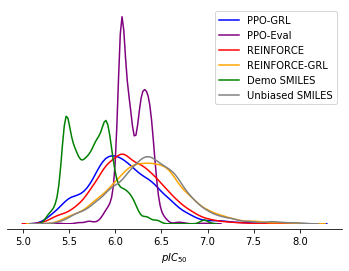

In [17]:
sns.kdeplot(preds_ppo_grl_smiles, label='PPO-GRL', shade=False, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles, label='PPO-Eval', shade=False, color='purple')
sns.kdeplot(preds_reinforce_smiles, label='REINFORCE', shade=False, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles, label='REINFORCE-GRL', shade=False, color='orange')
sns.kdeplot(preds_demo_smiles, label='Demo SMILES', shade=False, color='green')
ax = sns.kdeplot(preds_unbiased_smiles, label='Unbiased SMILES', shade=False, color='gray')
plt.xlabel('$pIC_{50}$')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('jak2_min/jak2_min_kde_plots.pdf')
plt.show()

## Convergence plot

In [18]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

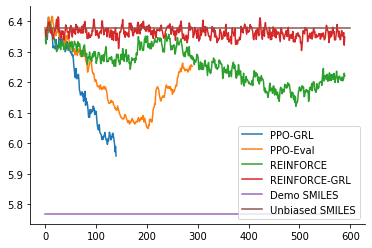

In [20]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:150])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
plt.savefig('jak2_min/jak2_min_irl_vs_rl_convergence.pdf')
sns.despine()

## t-SNE plot

In [24]:
hparams = {'d_model': 1500,
            'dropout': 0.0,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 10,
            'gae_lambda': 0.95,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 5,
            'entropy_beta': 0.01,
            'bias_mode': 'max',
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2,
                              'd_model': 512,
                              'unit_type': 'gru',
                              'demo_batch_size': 32,
                              'irl_alg_num_iter': 5,
                              'dropout': 0.2,
                              'use_attention': False,
                              'use_validity_flag': True,
                              'bidirectional': True,
                              'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.0005,
                              'optimizer__global__lr': 0.001, },
            'agent_params': {'unit_type': 'gru',
                             'num_layers': 2,
                             'stack_width': 1500,
                             'stack_depth': 200,
                             'optimizer': 'adadelta',
                             'optimizer__global__weight_decay': 0.005,
                             'optimizer__global__lr': 0.001},
            'critic_params': {'num_layers': 2,
                              'd_model': 256,
                              'dropout': 0.2,
                              'unit_type': 'gru',
                              'optimizer': 'adam',
                              'optimizer__global__weight_decay': 0.005,
                              'optimizer__global__lr': 0.001},
            'expert_model_dir': './model_dir/expert_xgb_reg'
            }

In [22]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [23]:
encoder = init_dict['encoder']
ppo_reward_net_rnn = init_dict['reward_net_rnn']
ppo_reward_net = init_dict['reward_net']
ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/JAK2_max_irelease_stack-rnn_gru_ppo_reward_net_2020_07_12__20_54_23_1.003_66.mod'))

<All keys matched successfully>

In [ ]:
with torch.set_grad_enabled(False):
    reward_lst, logits_lst = [], []
    tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
    for i in range(0, len(tsne_smiles), 500):
        inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+500]])
        enc_out = encoder([inp, valid_vec])
        reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
        reward_lst.append(reward)
        logits_lst.append(logits)
    reward = -torch.cat(reward_lst)
    logits = torch.cat(logits_lst)

In [ ]:
logits.shape, reward.shape

In [ ]:
tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
tsne_rep.shape

In [ ]:
plt.figure(figsize=(10,10))
points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
cb = plt.colorbar(points, ticks=None)
cb.outline.set_visible(False)
ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
                    legend=False, palette='Spectral', edgecolor='black', linewidth=.01)
v = []
# valid SMILES
while True:
    va_idx = np.random.randint(len(ppo_grl_smiles_valid))
    comp = ppo_grl_smiles_valid[va_idx]
    i = len(v)+1
    if len(comp) <= 50:
        v.append(comp)
        ax.annotate('val-'+str(i), xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
                    xytext=(-20+(i*10),50), 
                    arrowprops=dict(facecolor='black', arrowstyle='-'),
                   horizontalalignment='right', verticalalignment='top')
        if len(v) == 3:
            break

inv = []
# invalid SMILES
for i in range(3):
    inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
    inv.append(ppo_grl_smiles_invalid[inv_idx])
    ax.annotate('inv-'+str(i+1), xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
                    tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
                xytext=(-50+(i*10),40), arrowprops=dict(facecolor='black', arrowstyle='-'),
               horizontalalignment='right', verticalalignment='top')

print('selected valid:\n', v)
print('selected invalid:\n', inv)
plt.axis('off')
plt.savefig('jak2_max/jak2_max_ppo_grl_tsne.pdf')
plt.show()

##  Draw random SMILES

In [ ]:
vis_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_grl_smiles_valid) if len(sm)]# <= 50]
sanitized_gen_mols = [vis_mols[i] for i in np.where(np.array(vis_mols) != None)[0]]
len(sanitized_gen_mols)

In [ ]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [110]:
# Save selected compounds to file
# os.makedirs('./drd2_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./drd2/sample_compound_{i+1}.png')

## Molecule metrics

In [162]:
def mol_metrics(df):
    results = {}
    for idx, df_smiles in enumerate([df, df[df['prediction'] >= 0.8]]):
        new_smiles, valid_vec = canonical_smiles(df_smiles['SMILES'].tolist())
        smiles = []
        for i, s in enumerate(new_smiles):
            if valid_vec[i] == 1:
                smiles.append(s)
        eval_dict = nbu.evaluate(smiles, demo_smiles)
        eval_dict['Num of canonical SMILES'] = len(smiles)
        if idx==1:
            eval_dict['percentage in threshold'] = df_smiles.shape[0] / df.shape[0] * 100.
            eval_dict['percentage in threshold (canonical)'] = len(smiles) / df.shape[0] * 100.
        results['no_threshold' if idx==0 else 'with_threshold'] = eval_dict
    return results

In [163]:
mol_metrics(preds_ppo_grl_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.18857035237130135,
  'internal_diversity': 0.8867909614983127,
  'conciseness': 1.0,
  'solubility': 0.8866028578764165,
  'naturalness': 0.6737815877250535,
  'synthesizability': 0.5794447603940279,
  'druglikeliness': 0.2707620798674448,
  'Num of canonical SMILES': 3264},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.09514688331658416,
  'internal_diversity': 0.8588411209972447,
  'conciseness': 1.0,
  'solubility': 0.9451272614847471,
  'naturalness': 0.7157164193673897,
  'synthesizability': 0.49504268914952776,
  'druglikeliness': 0.16752441193513015,
  'Num of canonical SMILES': 2252,
  'percentage in threshold': 69.03087740752063,
  'percentage in threshold (canonical)': 68.8474472638337}}

In [164]:
mol_metrics(preds_ppo_baseline_reward_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.18269190953756917,
  'internal_diversity': 0.8776093409541392,
  'conciseness': 1.0,
  'solubility': 0.885274109286915,
  'naturalness': 0.7222516475882325,
  'synthesizability': 0.5211282766319629,
  'druglikeliness': 0.23629006742960168,
  'Num of canonical SMILES': 4538},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.08153201647377437,
  'internal_diversity': 0.8430912421458194,
  'conciseness': 1.0,
  'solubility': 0.9546380622474557,
  'naturalness': 0.7619020135984945,
  'synthesizability': 0.4471687919755744,
  'druglikeliness': 0.13157507572276836,
  'Num of canonical SMILES': 3269,
  'percentage in threshold': 72.00704225352112,
  'percentage in threshold (canonical)': 71.94102112676056}}

In [165]:
mol_metrics(preds_reinforce_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3250513101127702,
  'internal_diversity': 0.9042709966824587,
  'conciseness': 1.0,
  'solubility': 0.8016245803379475,
  'naturalness': 0.7025041489348428,
  'synthesizability': 0.7178129985022191,
  'druglikeliness': 0.44342409317476356,
  'Num of canonical SMILES': 7393},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.20519346794590151,
  'internal_diversity': 0.8842035122769324,
  'conciseness': 1.0,
  'solubility': 0.8414245674632197,
  'naturalness': 0.7199703908271272,
  'synthesizability': 0.7059804075652,
  'druglikeliness': 0.3813380860474462,
  'Num of canonical SMILES': 4588,
  'percentage in threshold': 62.02565833896016,
  'percentage in threshold (canonical)': 61.95813639432816}}

In [166]:
mol_metrics(preds_reinforce_grl_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.5132832093923956,
  'internal_diversity': 0.9239257580152366,
  'conciseness': 1.0,
  'solubility': 0.8463718541727862,
  'naturalness': 0.7941316737207141,
  'synthesizability': 0.29328565126728745,
  'druglikeliness': 0.30366703501285053,
  'Num of canonical SMILES': 541},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.19793150926694927,
  'internal_diversity': 0.9046073695944687,
  'conciseness': 1.0,
  'solubility': 0.9254773301811249,
  'naturalness': 0.8382723585854317,
  'synthesizability': 0.22930164474975898,
  'druglikeliness': 0.1928769594483923,
  'Num of canonical SMILES': 142,
  'percentage in threshold': 26.199261992619927,
  'percentage in threshold (canonical)': 26.199261992619927}}

In [167]:
mol_metrics(preds_demo)

{'no_threshold': {'novelty': 0.9911,
  'hard_novelty': 0.9911,
  'soft_novelty': 0.99377,
  'external_diversity': 0.08888893770764128,
  'internal_diversity': 0.8969069140069144,
  'conciseness': 1.0,
  'solubility': 0.7767210383965386,
  'naturalness': 0.5357496152445249,
  'synthesizability': 0.637410211161941,
  'druglikeliness': 0.6035345842617676,
  'Num of canonical SMILES': 10000},
 'with_threshold': {'novelty': 0.9899275490369324,
  'hard_novelty': 0.9899275490369324,
  'soft_novelty': 0.9929492843258527,
  'external_diversity': 0.07942108322949015,
  'internal_diversity': 0.8961781082411568,
  'conciseness': 1.0,
  'solubility': 0.793521853657565,
  'naturalness': 0.5234727649794746,
  'synthesizability': 0.6428137610891071,
  'druglikeliness': 0.588815578381265,
  'Num of canonical SMILES': 5659,
  'percentage in threshold': 56.589999999999996,
  'percentage in threshold (canonical)': 56.589999999999996}}

In [168]:
mol_metrics(preds_unbiased)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.38132219434661285,
  'internal_diversity': 0.9172257350533534,
  'conciseness': 1.0,
  'solubility': 0.6609464611090811,
  'naturalness': 0.557850558734029,
  'synthesizability': 0.6367046437546721,
  'druglikeliness': 0.602456357814084,
  'Num of canonical SMILES': 10000},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.40009373509177404,
  'internal_diversity': 0.9179330164328013,
  'conciseness': 1.0,
  'solubility': 0.6896322947022103,
  'naturalness': 0.5884228697409833,
  'synthesizability': 0.5855403373223457,
  'druglikeliness': 0.6038581638891619,
  'Num of canonical SMILES': 2030,
  'percentage in threshold': 20.3,
  'percentage in threshold (canonical)': 20.3}}

## RNN hidden neurons examination

In [169]:
# def plot_heatmap(smiles_list, logits, neuron=None, save=False):
#     if neuron is None:
#         neuron = np.random.randint(logits.shape[-1])
#     print(f'Plotting for neuron {neuron}')
#     for i, smiles in enumerate(smiles_list):
#         arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
#         chars = np.array([c for c in smiles]).reshape(1,-1)
#         fig = plt.figure(figsize=(200,4))
#         sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
#                     cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
#                    xticklabels=False, yticklabels=False, square=True)
#         if save:
#             os.makedirs(f'drd2/neuron_{neuron}', exist_ok=True)
#             plt.savefig(f'drd2/neuron_{neuron}/{i}.png')
#         plt.show()

In [ ]:
# plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])